# Brain age prediction

Brain MRI is represented by a three-dimensional tensor where each voxel contains a gray intensity. 

The goal is to visualize the brain anatomy.

The idea of this notebook is to predict the brain age of a subject from his brain MRI.

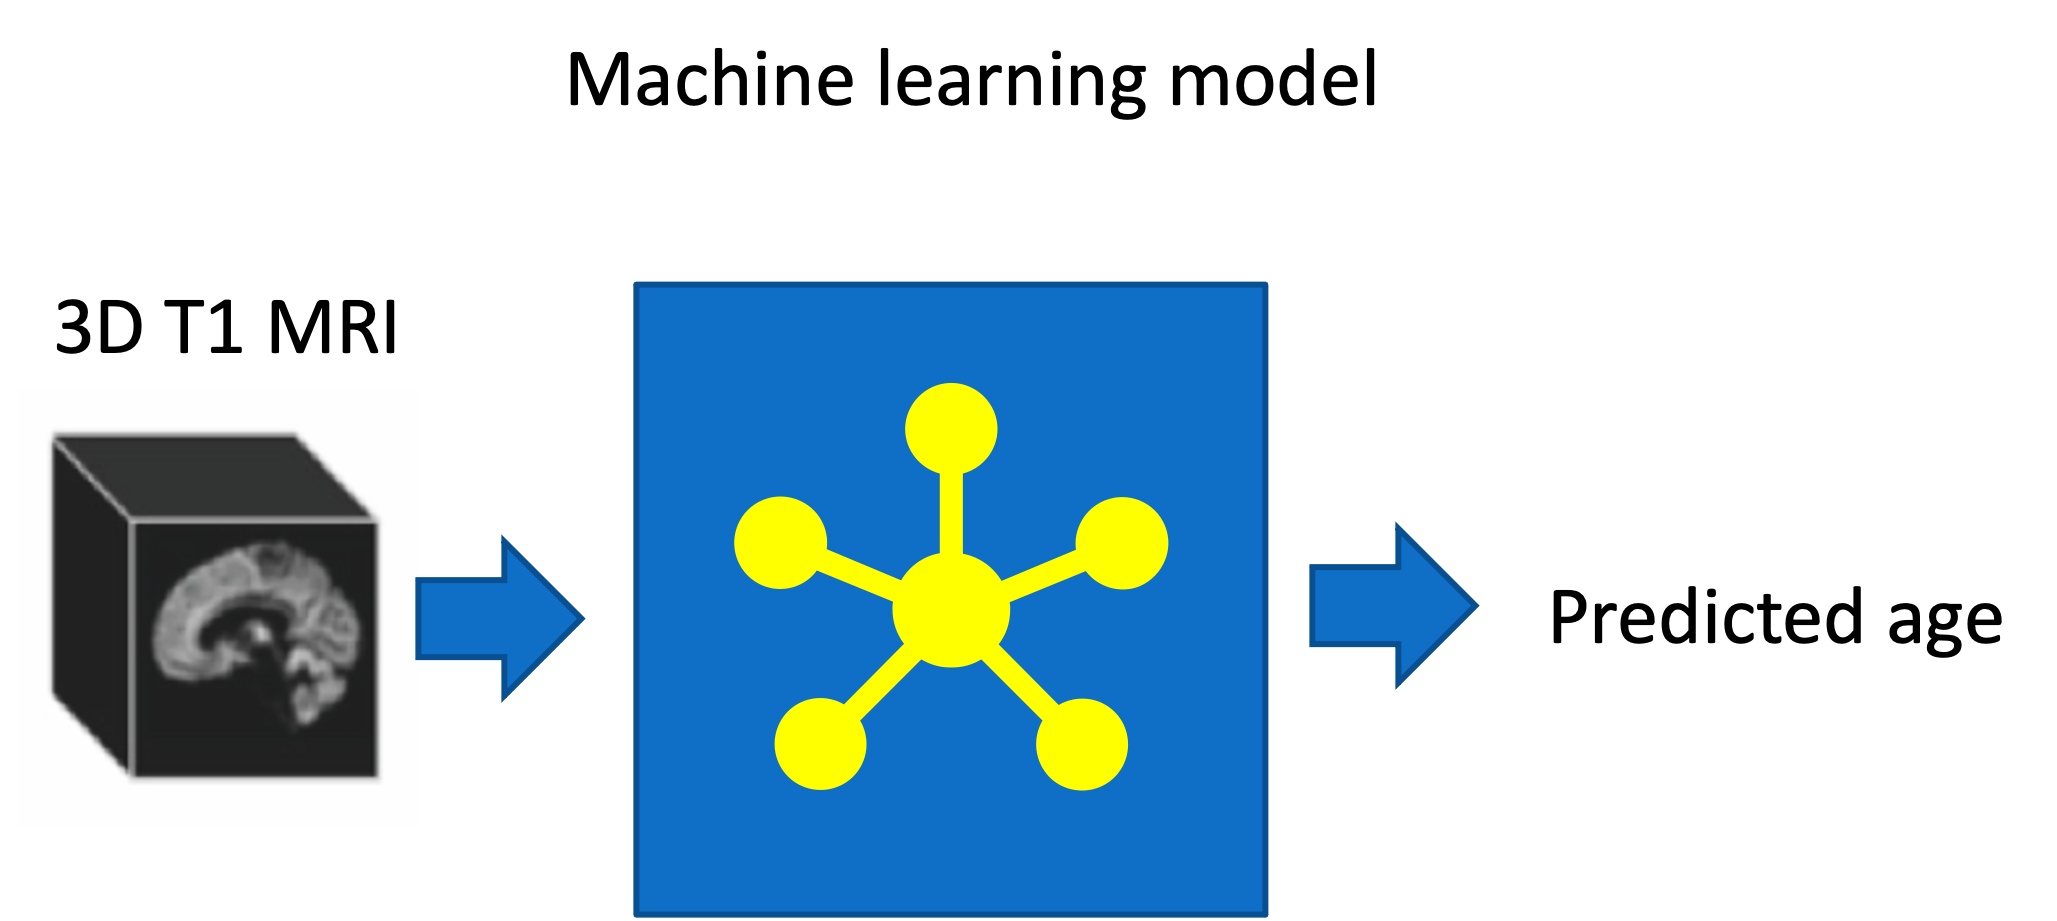


## Selecting the GPU

Before we start we will select the appropriate hardware for our notebook. Deep learning needs graphic cards (GPU) in order to reduce the calculation time.

Press on **Exécution** -> **Modifier le type d'exécution** > select **Accélérateur matériel** and save the setting. 

## Sync with Google Drive

Click on the link below: 

https://drive.google.com/open?id=1bqPk6SasqrUOBB7jfGLb8lRxNdBp9cBY

Right click on the **tp_4** folder and press **Ajouter à mon Drive**.

<img src="https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/images/data_google_drive.png?raw=1" width="800" >

Run the cell below and press the link provided. 

Follow the instructions and copy the code below.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

The data is now in your colab environment.

## Packages importation

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dense, Flatten, ReLU
from tensorflow.keras.layers import BatchNormalization

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nibabel
import sys
import os
import datetime

# Model architecture

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import ReLU, PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint


from keras.callbacks import Callback


import nibabel as nib
import seaborn as sns
from scipy.signal import find_peaks

In [ ]:
# own bibli
os.chdir("/content/gdrive/My Drive/tp_4/data/utils/")
from callbacks import SaveHyperparameters, SaveMetrics
from utils import train_test_val
from models import model_Cole
from generators import generator_mri_regression

## Data loading

Loading of the training data

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/tp_4/data/train.csv')
data.head()

### **Exercice**

Plot the distribution of the age for the training set

In [ ]:
### Start Your Code ###

### End Your Code ###
plt.show()

### **Expected result**

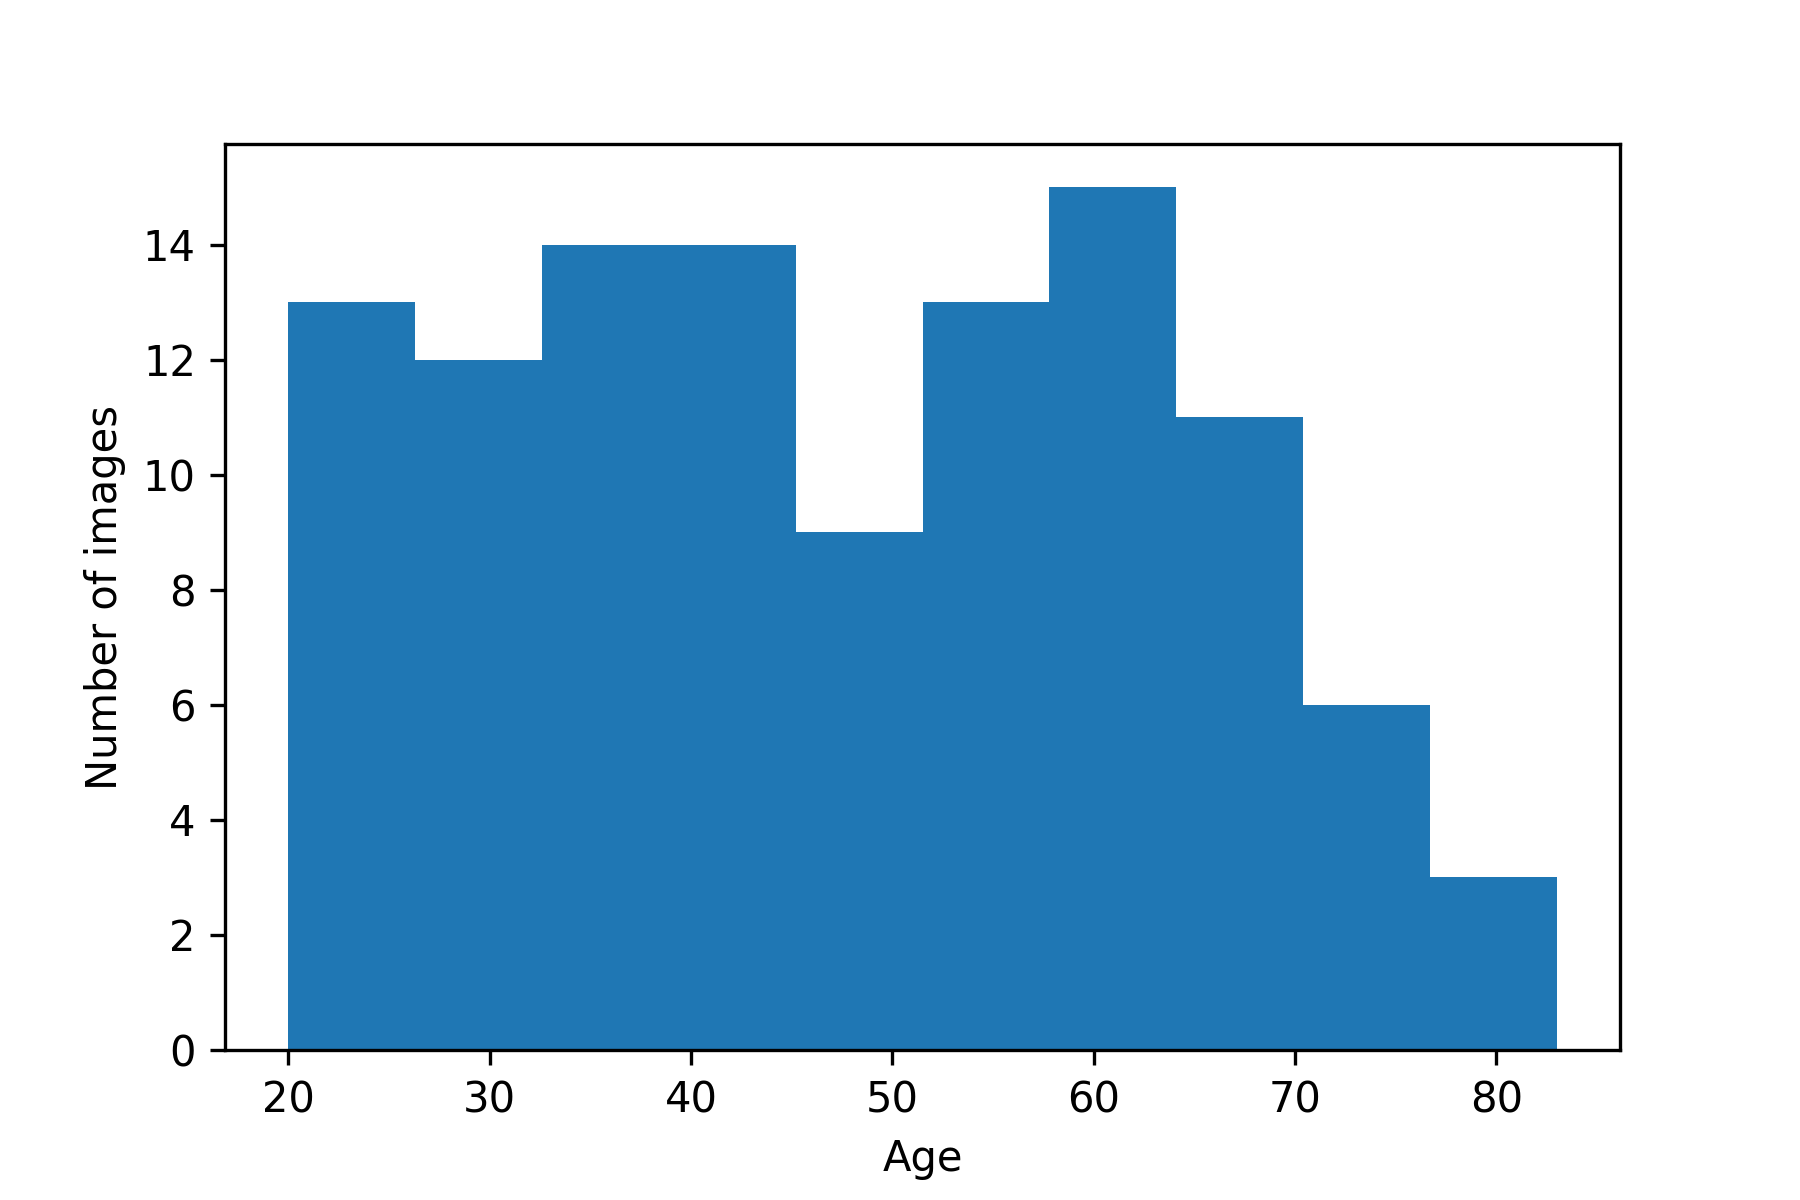

Loading of the testing data

In [ ]:
data_test = pd.read_csv('/content/gdrive/My Drive/tp_4/data/test.csv')
data_test.head()

### **Exercice**

Plot the distribution of the age for the testing set

In [ ]:
### Start Your Code ###

### End Your Code ###
plt.show()

### **Expected result**

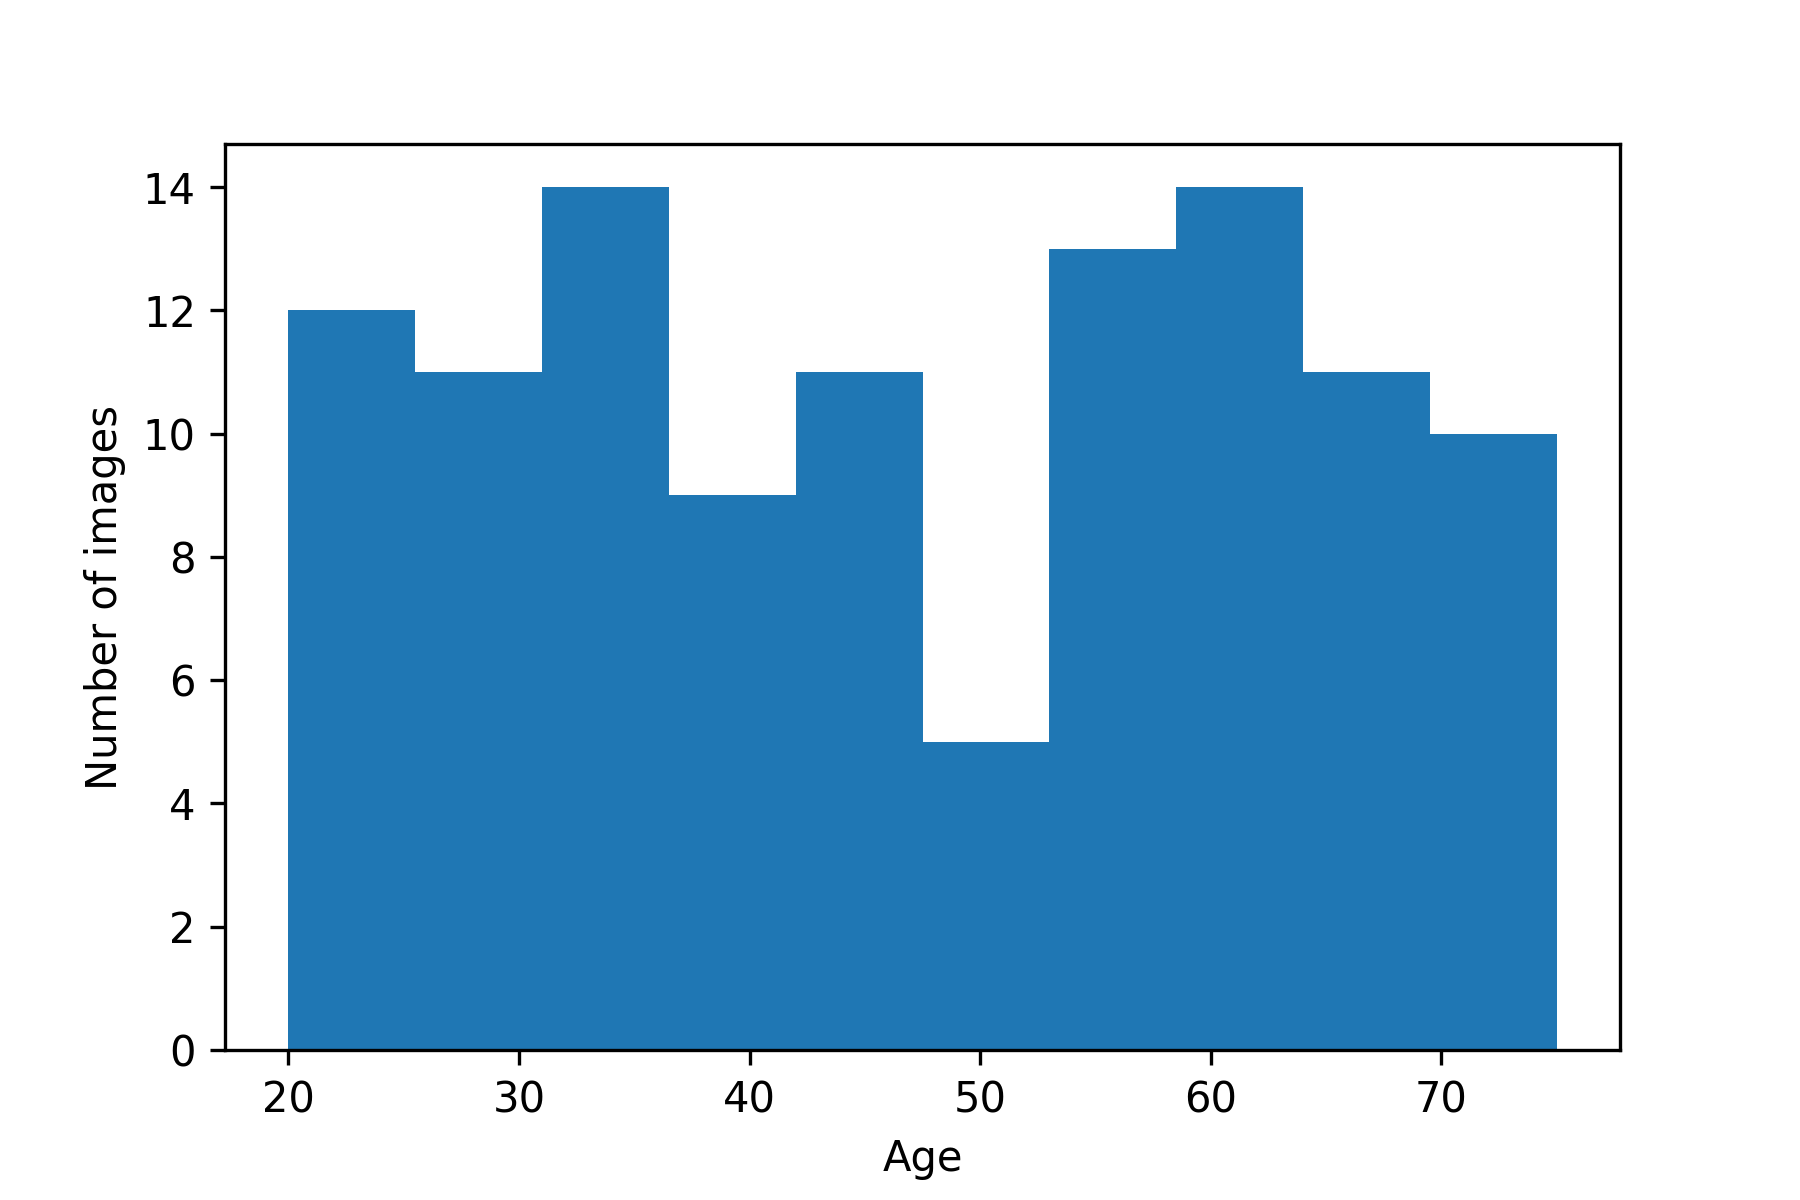

## MRI visualization

Let's try to read the first example of the training set.

In [ ]:
data.loc[0, 't1_norm']

To read our data we will use the nibabel package here with the abbreviation **nib**.

In [ ]:
nib_object = nib.load(data.loc[0, 't1_norm'])

We get a nibabel object which is the association of three things:
*   An affine array that tells you the position of the image array data in a reference space.

In [ ]:
print(nib_object.affine)

* The image data array

In [ ]:
numpy_object = nib_object.get_fdata()
print(numpy_object.shape)

* image metadata describing the image

In [ ]:
print(nib_object.header)

We are going to code a function **show_slices** that will allow us to visualize slices of our brain image in three dimensions.

In [ ]:
from re import T
def show_slices(slices, title):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].title.set_text(title[i])

We will use the previous function to visualize a coronal, axial and sagittal slice.

In [ ]:
# Sagittal
slice_0 = numpy_object[100, :, :]

# Coronal
slice_1 = numpy_object[:, 120, :]
slice_1 = slice_1.T
slice_1 = np.flip(slice_1,axis=1)

# Axial
slice_2 = numpy_object[:, :, 90]

show_slices([slice_0, slice_1.T, slice_2], ['Sagittal', 'Coronal', 'Axial'])
plt.show()

## MRI generator

Often in deep learning the training and test sets are too big to be loaded in memory. 

To train our models we are forced to train our models by mini-batch. A batch is a fraction of our training set. 

<img src='https://github.com/MorganGautherot/Tuto_MRI_ML/blob/master/tp_4/data/mini-batch.png?raw=1' >

Consider a training set X with $n_x$ the number of variables and $m$ the number of examples. 

Let's imagine that our dataset is equal to $m$=50,000,000, training this model is impossible. To make training possible, we will train several $X^{\{i\}}$ mini-batches to train all our examples sequentially.

To simulate these mini-batches we will use generators that will provide the algorithm with data by sequence.


We will create a class which will be a dataset wrapper for better training performance.

### Class initialization

In [ ]:
class generator_mri():
    
    # Class is a dataset wrapper for better training performance
    def __init__(self, list_path, batch_size=8):
        self.list_path = list_path
        self.batch_size = batch_size
        self.len = np.ceil(len(self.list_path) / self.batch_size)
        self.idx = 0


In [ ]:
gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=8)

We can have access to all the data pass in parameter and more.

**The list of the data**

In [ ]:
print(gen.list_path)

**The batch size**

In [ ]:
print(gen.batch_size)

**How many step per epoch**

In [ ]:
print(gen.len)

**The id of the current batch element in the epoch**

In [ ]:
print(gen.idx)

### Norm

**Exercice**

Create a function *\_\_norm__*

The function apply the MinMax normalization:

$$ x_{norm} = \frac{x-x_{min}}{x_{max}-x_{min}}$$ 


In [ ]:
class generator_mri():
    
    # Class is a dataset wrapper for better training performance
    def __init__(self, list_path, batch_size=8):
        self.list_path = list_path
        self.batch_size = batch_size
        self.len = np.ceil(len(self.list_path) / self.batch_size)
        self.idx = 0
 
    def __norm__(self, batch):
        ### Start Your Code ###
        batch_norm = None
        ### End Your Code ###
        return batch_norm


In [ ]:
np.random.seed(123)
test = np.random.randint(0, 12, size=[5, 3, 3, 3])
print(np.max(test))
print(np.min(test))

In [ ]:
gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=8)
test_norm = gen.__norm__(test)
print(np.max(test_norm))
print(np.min(test_norm))

[Excepted result]

1.0

0.0

### Getitem

**Exercice** 

Create a function *\_\_getitem__*

Take the images of the current batch

HINT : self.idx give you the index of the next image

In [ ]:
class generator_mri():
    

    ### Copy Paste your previous function Start ###

    
    ### Copy Paste your previous function End ###


    def __getitem__(self):

        ### Start your Code ###

        # Find a way to get the index of the final image of the batch

            
        # Take the path of every images of the batch
        # Hint : use .iloc[]
        batch_idx = None

        # Import every image of your batch
        # Hint : use the function load from nibabel
        batch_img = None

        # Use the function to normalize your batch 
        batch_img_norm = None

        ### End your code ###

        return batch_img_norm

In [ ]:
gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=8)

gen.__getitem__().shape

[Expected result]

(9, 193, 229, 193)

### Gettarget

**Exercice** 

Create a function *\_\_gettarget__*

Take the target value of the current batch

HINT : self.idx give you the index of the next image

In [ ]:
class generator_mri():
    

    ### Copy Paste your previous function Start ###



    ### Copy Paste your previous function End ###

    def __gettarget__(self):

        ### Start your code ###

        # Find a way to get the index of the final image of the batch
        # Think about the end of the batch

            
        # Take the target value for every examples of the batch
        batch = None

        ### End your code ###

        return batch

In [ ]:
gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=8)

gen.__gettarget__()

[Expected result]

0    21.0

1    20.0

2    23.0

3    24.0

4    24.0

5    24.0

6    23.0

7    20.0

### loader

**Exercice** 

Create a function *\_\_getbatch__*

Return the pair image, target value.

Hint : Use both *\_\_getitem__* and *\_\_gettarget__*

In [ ]:
class generator_mri():
    

    ### Copy Paste your previous function Start ###


    ### Copy Paste your previous function End ###
            
    # Generate flow of data
    def loader(self):

        # load data from somwhere with Python, and yield them    
        while True:

        ### Start your code ###

            # Use __getitem__ to get the image
            batch_input = None

            # Use __gettarget__ to get the target value
            batch_output = None

            # Increment idx with its new value. 
            # Be careful to take into account the return to zero if idx exceeds len.

        ### End your code ###

            yield (batch_input, batch_output)

In [ ]:
gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=8)

for i in np.arange(gen.len):
  batch = next(gen.loader())
  x = batch[0]
  y = batch[1]
  print(x.shape)
  print(y.shape)

[Expected results]

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(8, 193, 229, 193)

(8,)

(6, 193, 229, 193)

(6,)

## Deep learning architecture

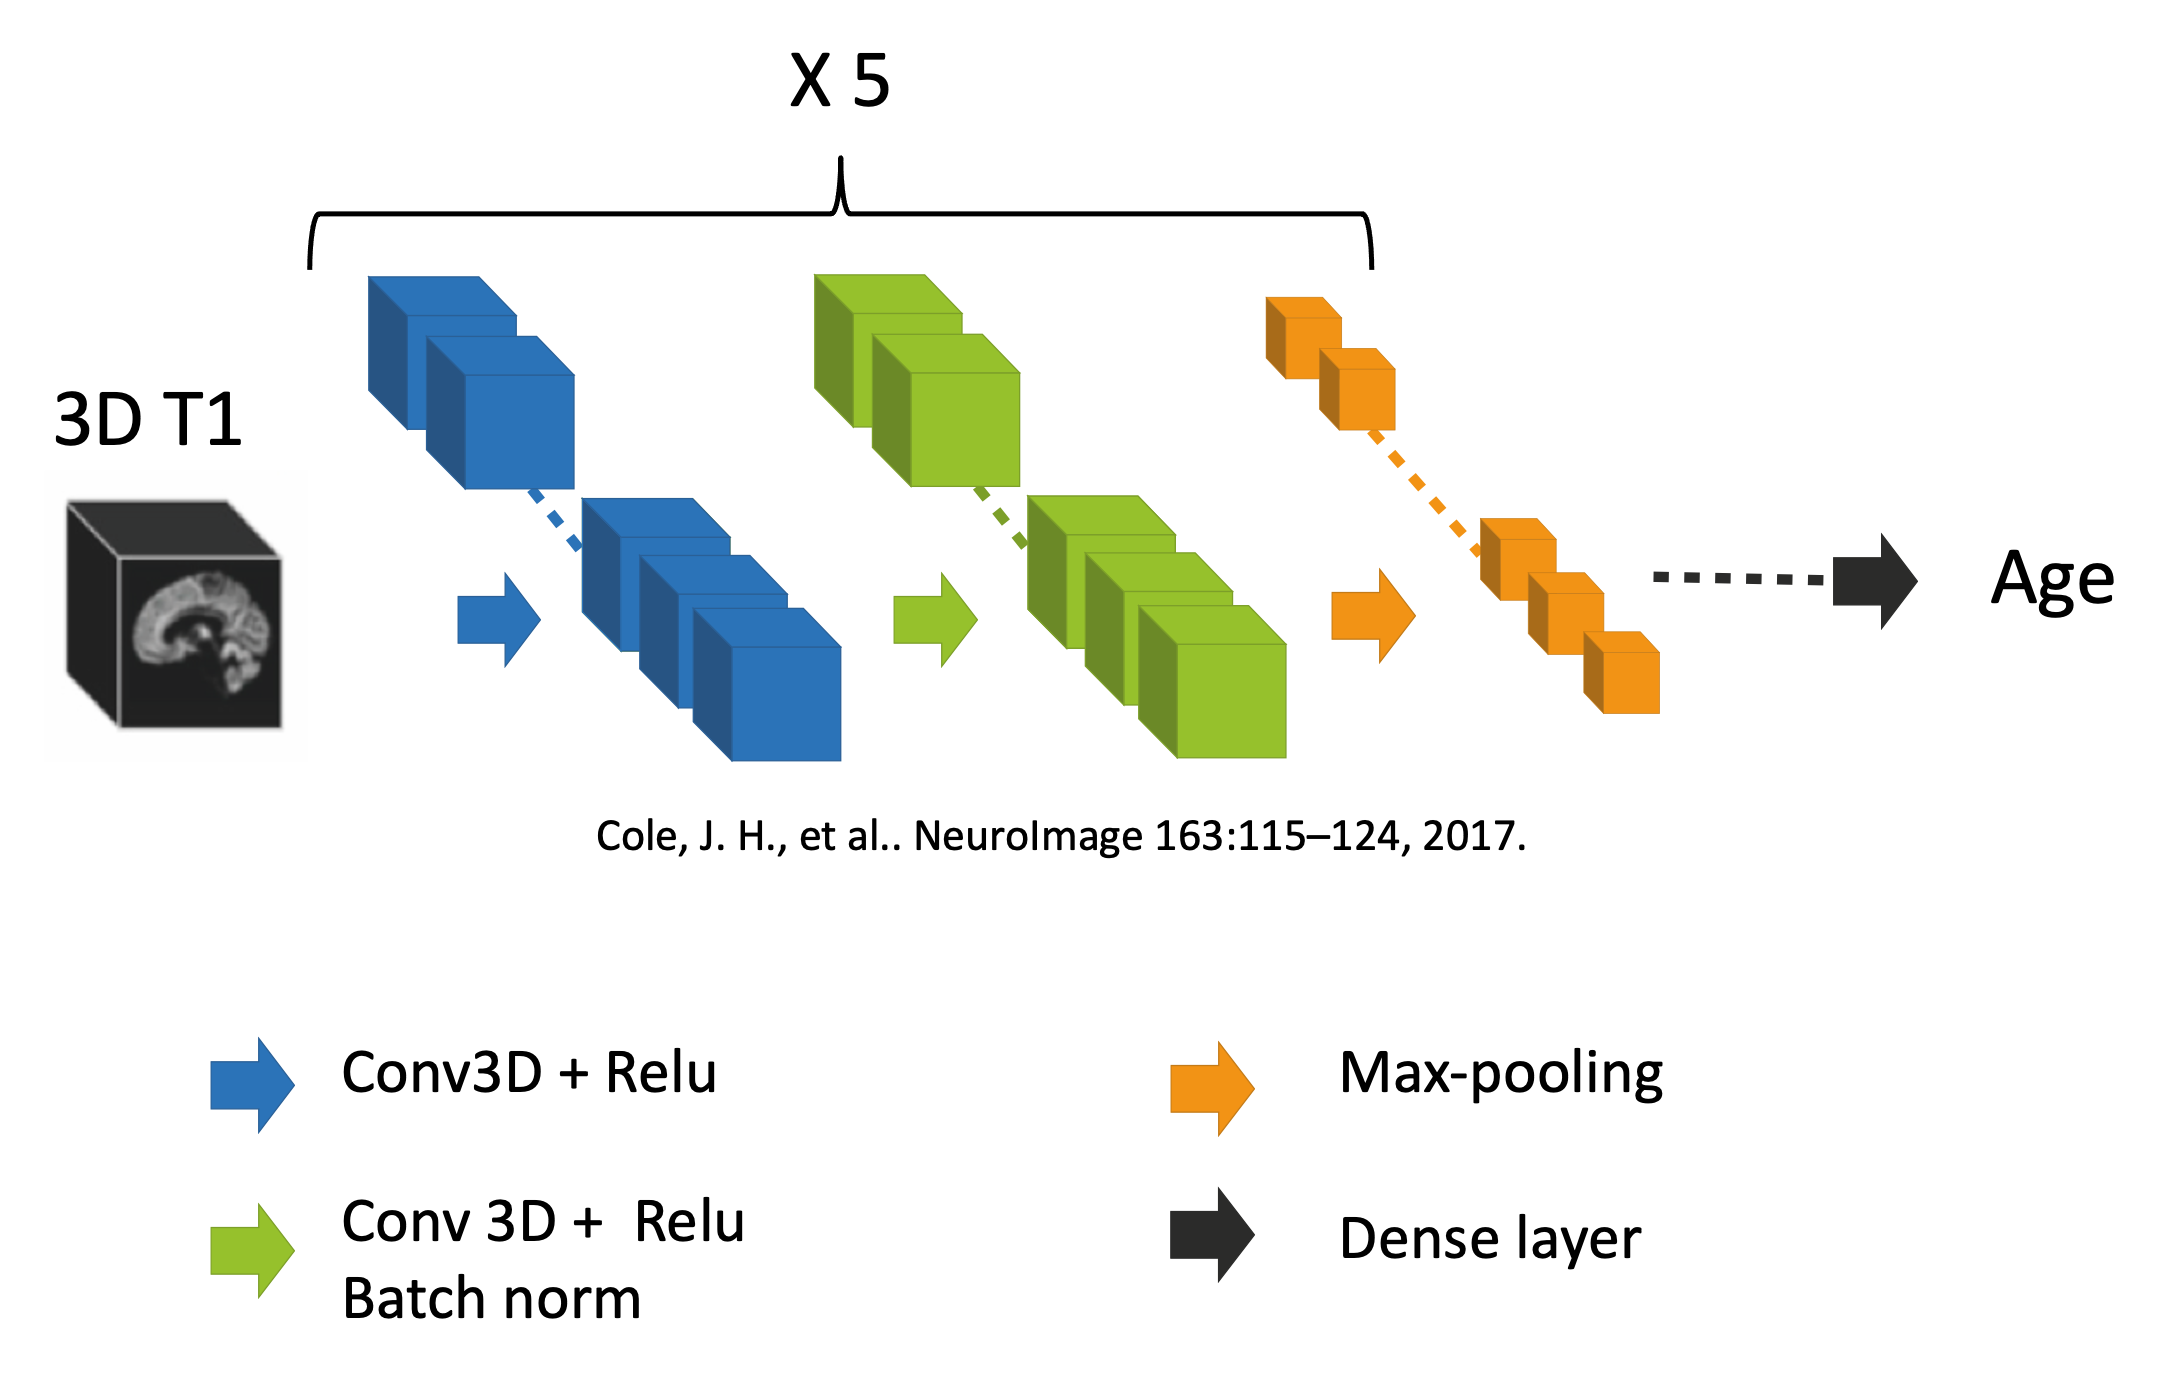

**Exercice** 

You have to initialize this network architecture.

Use a strie of 2 and a windows of 2 for MaxPooling layers

Use a windows of 3 for the convolution filter

In [ ]:
### Start your code ###

model = None

### End your code ###

In [ ]:
model.summary()

[Expected result]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 conv_1_1 (Conv3D)           (None, 193, 229, 193, 8)  224       
                                                                 
 conv_1_2 (Conv3D)           (None, 193, 229, 193, 8)  1736      
                                                                 
 bn_1_3 (BatchNormalization)  (None, 193, 229, 193, 8)  772      
                                                                 
 relu_conv_1_4 (ReLU)        (None, 193, 229, 193, 8)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 96, 114, 96, 8)   0         
 )                                                               
                                                                 
 conv_2_1 (Conv3D)           (None, 96, 114, 96, 16)   3472      
                                                                 
 conv_2_2 (Conv3D)           (None, 96, 114, 96, 16)   6928      
                                                                 
 bn_2_3 (BatchNormalization)  (None, 96, 114, 96, 16)  384       
                                                                 
 relu_conv_2_4 (ReLU)        (None, 96, 114, 96, 16)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 48, 57, 48, 16)   0         
 3D)                                                             
                                                                 
 conv_3_1 (Conv3D)           (None, 48, 57, 48, 32)    13856     
                                                                 
 conv_3_2 (Conv3D)           (None, 48, 57, 48, 32)    27680     
                                                                 
 bn_3_3 (BatchNormalization)  (None, 48, 57, 48, 32)   192       
                                                                 
 relu_conv_3_4 (ReLU)        (None, 48, 57, 48, 32)    0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 24, 28, 24, 32)   0         
 3D)                                                             
                                                                 
 conv_4_1 (Conv3D)           (None, 24, 28, 24, 64)    55360     
                                                                 
 conv_4_2 (Conv3D)           (None, 24, 28, 24, 64)    110656    
                                                                 
 bn_4_3 (BatchNormalization)  (None, 24, 28, 24, 64)   96        
                                                                 
 relu_conv_4_4 (ReLU)        (None, 24, 28, 24, 64)    0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 12, 14, 12, 64)   0         
 3D)                                                             
                                                                 
 conv_5_1 (Conv3D)           (None, 12, 14, 12, 128)   221312    
                                                                 
 conv_5_2 (Conv3D)           (None, 12, 14, 12, 128)   442496    
                                                                 
 bn_5_3 (BatchNormalization)  (None, 12, 14, 12, 128)  48        
                                                                 
 relu_conv_5_4 (ReLU)        (None, 12, 14, 12, 128)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 7, 6, 128)     0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 32256)             0         
                                                                 
 d_6 (Dense)                 (None, 1)                 32257     
                                                                 
_________________________________________________________________
Total params: 917,469

Trainable params: 916,723

Non-trainable params: 746
_________________________________________________________________

**Exercice** 

Compile your model

Use rsmprop as optimizer with a learning rate of 0.01

use mae as loss and metrics

In [ ]:
### Start your code ###

### End your code

## Initialize callbacks

You will initiliaze Callbacks to save your best model during the training using the function *ModelCheckpoint*.

In [ ]:
filepath="/content/model_saved/"
os.mkdir(filepath)

### Start Your Code ###
checkpoint = None
### End Your Code ###

## Model training

Initialization of the train et test generator

In [ ]:
train_gen  = generator_mri(data.loc[:, ['t1_norm', 'age']], batch_size=4)
test_gen  = generator_mri(data_test.loc[:, ['t1_norm', 'age']], batch_size=4)

**Exercice**

Use the function *fit_generator* to train the model.

Use these hyperparameters: 
- epochs = 5
- validation_freq = 1
- generator
- steps_per_epoch
- validation_data
- validation_steps
- callbacks

In [ ]:
### Start your code ###

### End your code ###

## Performance visualization

In [ ]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

Visualize the decrease of loss of the model, epoch by epoch.

In [ ]:
### Start Your Code ###

### End Your Code ###
plt.show()

You have to find a graph which look like the one below.

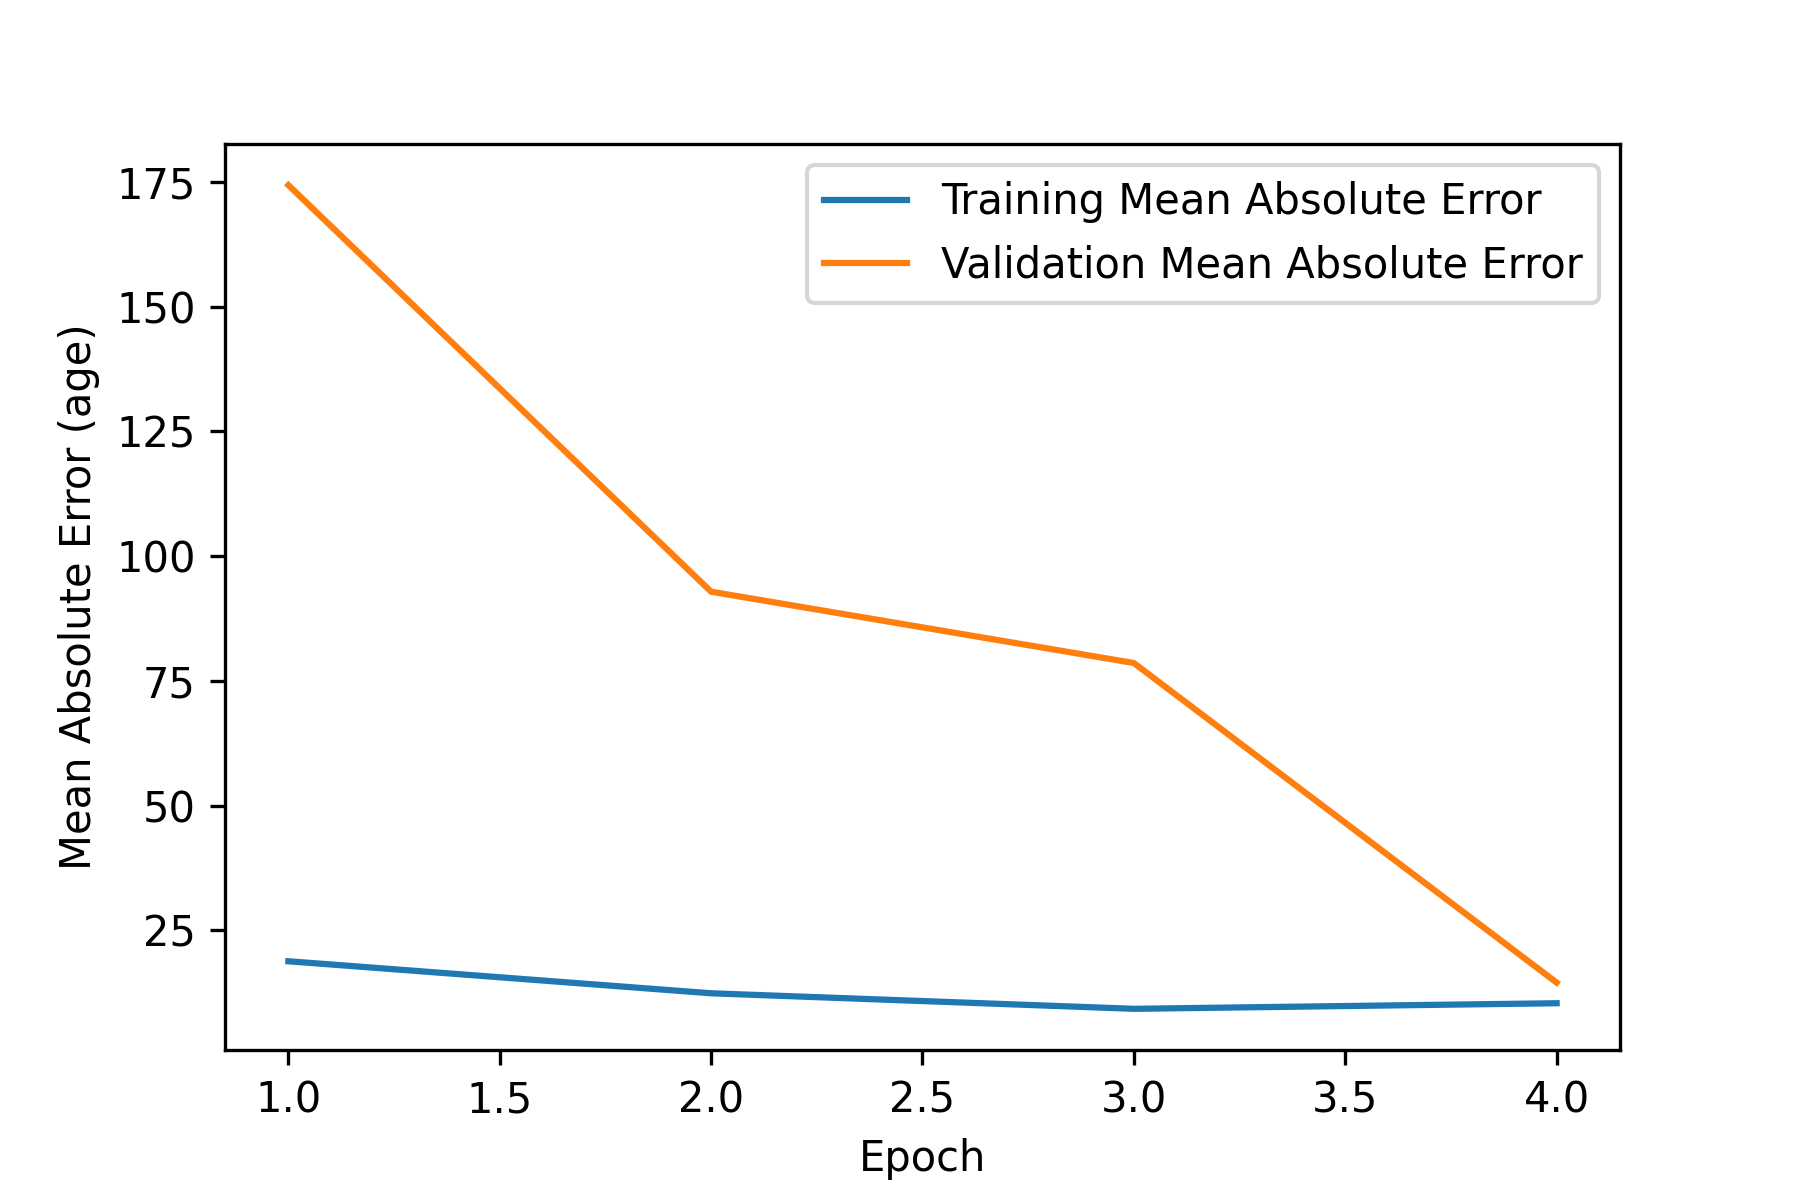

## Load weights

You can load a training of this model during 100 epochs on the same data

In [ ]:
model.load_weights('/content/gdrive/My Drive/tp_4/data/models/model-cole_it-100_data-100.hdf5')

You can see the decrease of the loss through time.

In [ ]:
data_training = pd.read_csv("/content/gdrive/My Drive/tp_4/data/training_data/metrics_cole_100_100.csv")
plt.plot(data_training.loc[:, 'epoch'], data_training.loc[:, 'train_loss'], label='Training Mean Absolute Error')
plt.plot(data_training.loc[:, 'epoch'], data_training.loc[:, 'val_loss'], label='Validation Mean Absolute Error')
plt.legend(loc='upper right')
plt.title('Evolution of the error during the training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (age)')
plt.show()

## Next step ?

Now that you have train your first model the idea will be to test several assumptions to improve the performance of your model. 

For example :
- Use more data for training, 
- Integrate data augmentation in the generator, 
- Use regularization techniques (drop-out, l2 penalty, ...)
- Use a learning rate decay
- ...

These are only examples, there are still many other things that can be imagined and that can improve the prediction of the model. 